In [2]:
import interfere
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 10)

SEED = 11
NOTEBOOK_RNG = np.random.default_rng(SEED)
REPS = 1

# Inference Methods included in the `interfere` package

In [3]:
def uniform_init_cond(min_x, max_x, dim, reps, rng=NOTEBOOK_RNG):
    """Generates initial conditions for dynamic models."""
    return [
        (max_x - min_x) * rng.random(dim) + min_x for i in range(reps)
    ]

In [16]:
dim = 10

params = dict(
    model_type=interfere.dynamics.LotkaVolteraSDE,
    model_params={
        # All nodes have the same growth rate
        "growth_rates": np.ones(dim),
        "capacities": 20 * np.ones(dim),
        # Three cycle and isolated node
        "interaction_mat": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0.1,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 5.0},
    # Nodes begin synchronized but the intervention reveals coupling.
    initial_conds=uniform_init_cond(2, 2, dim, REPS),
    start_time=0, end_time=50, dt=0.01,
    rng = np.random.default_rng(SEED)
)


Xs, X_dos, t = interfere.generate_counterfactual_forecasts(**params)
X = Xs[0]
X_do = X_dos[0]

train_idx, dims = X_do.shape
X_historic = X[:-train_idx, :]
historic_times = t[:-train_idx]
forecast_times = t[-train_idx:]

In [21]:
method = interfere.methods.ResComp(res_sz=100, sigma=1/10, delta=5/10, gamma=0.01, window=1, spect_rad=5)

intervention = params["intervention_type"](**params["intervention_params"])
X_do_pred = method.counterfactual_forecast(
    X_historic, historic_times, forecast_times, intervention)

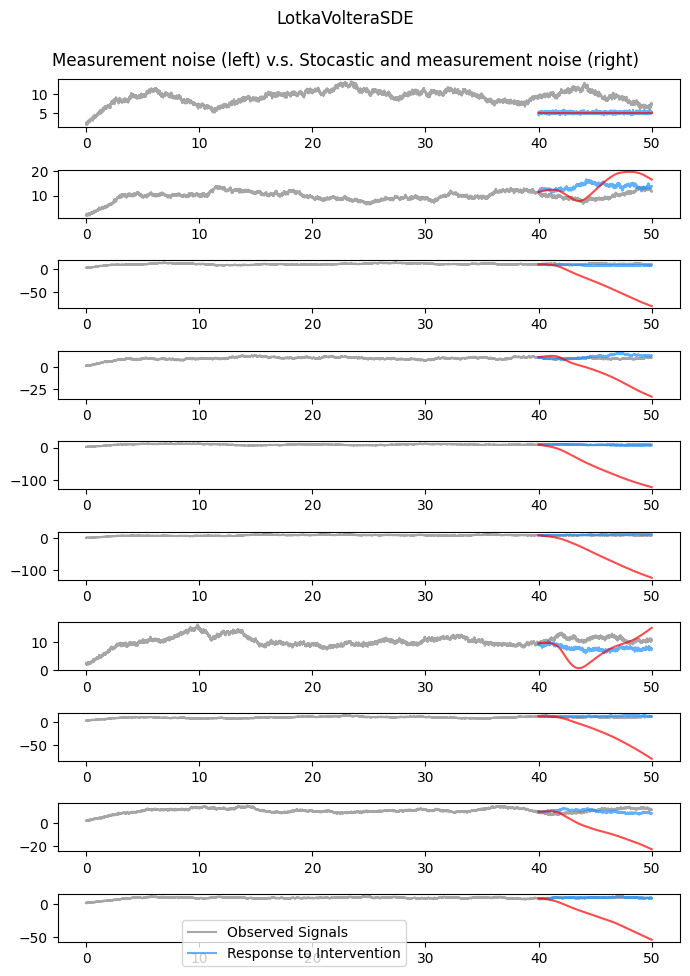

In [22]:
obs_sig_color = "gray"
response_sig_color = "dodgerblue"
pred_sig_color = "r"

train_idx, dims = X_do.shape
fig, ax = plt.subplots(dims, 1, figsize=(7, 10))
for i in range(dims):
    ax[i].plot(t, X[:, i], alpha=0.7, c=obs_sig_color)
    ax[i].plot(t[-train_idx:], X_do[:, i], alpha=0.7, c=response_sig_color)
    ax[i].plot(t[-train_idx:], X_do_pred[:, i], alpha=0.7, c=pred_sig_color)


ax[-1].plot([0, 0], [0, 0], alpha=0.7, c=obs_sig_color, label="Observed Signals")
ax[-1].plot([0, 0], [0, 0], alpha=0.7, c=response_sig_color, label="Response to Intervention")

plt.legend(loc=(0.2, -.5))
plt.suptitle(params["model_type"].__name__ + "\n\nMeasurement noise (left) v.s. Stocastic and measurement noise (right)")
plt.tight_layout()
plt.show()

In [24]:
ttest_change_acc = interfere.benchmarking.TTestDirectionalChangeAccuracy()
ttest_change_acc(X_historic, X_do, X_do_pred, intervention.intervened_idxs)

0.5555555555555556